In [2]:
import getpass
import sys
import pandas as pd
import string

from src.common.authentication import Authentication
from src.common.perspective_api_request import PerspectiveAPIRequest, PerspectiveAPIRequestResult
from src.common.request import Request, RequestResult
from src.proxy.accounts import Account
from proxy.remote_service import RemoteService

from os.path import exists

In [3]:
import json

# load data using Python JSON module
with open("jeopardy/data/jeopardy.json",'r') as f:
    data = json.loads(f.read())
# Flatten data
jeopardy_data = pd.json_normalize(data)


In [4]:
# An example of how to use the request API.
#api_key = getpass.getpass(prompt="Enter a valid API key: ")
api_key = pd.read_csv("prod_env/api_key.csv", header=None)[0].values[0]
auth = Authentication(api_key=api_key)
service = RemoteService("https://crfm-models.stanford.edu")

# Access account and show my current quotas and usages
account: Account = service.get_account(auth)
print(account.usages)

{'gpt3': {'daily': Usage(period='2022-8-15', used=109497, quota=None), 'total': Usage(period='all', used=196805, quota=400000), 'monthly': Usage(period='2022-8', used=159608, quota=None)}, 'codex': {'daily': Usage(period=None, used=0, quota=0)}, 'jurassic': {'daily': Usage(period=None, used=0, quota=None), 'total': Usage(period=None, used=0, quota=0)}, 'gooseai': {'daily': Usage(period=None, used=0, quota=0)}}


In [5]:
jeopardy_data = pd.json_normalize(data)
jeopardy_data['value'] = jeopardy_data['value'].str.replace(",", "")
# jeopardy_data['value'] = jeopardy_data['value'].str.replace("$", "")
jeopardy_data = jeopardy_data.dropna(subset='value')


In [6]:
#removing the quotes
jeopardy_data['question'] = jeopardy_data['question'].apply(lambda x: x[1:-1])
jeopardy_data

,category,air_date,question,value,answer,round,show_number
0,HISTORY,2004-12-31,"For the last 8 years of his life, Galileo was ...",$200,Copernicus,Jeopardy!,4680
1,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,No. 2: 1912 Olympian; football star at Carlisl...,$200,Jim Thorpe,Jeopardy!,4680
2,EVERYBODY TALKS ABOUT IT...,2004-12-31,The city of Yuma in this state has a record av...,$200,Arizona,Jeopardy!,4680
3,THE COMPANY LINE,2004-12-31,"In 1963, live on ""The Art Linkletter Show"", th...",$200,McDonald\'s,Jeopardy!,4680
4,EPITAPHS & TRIBUTES,2004-12-31,"Signer of the Dec. of Indep., framer of the Co...",$200,John Adams,Jeopardy!,4680
...,...,...,...,...,...,...,...
216924,OFF-BROADWAY,2006-05-11,In 2006 the cast of this long-running hit emba...,$2000,Stomp,Double Jeopardy!,4999
216925,RIDDLE ME THIS,2006-05-11,This Puccini opera turns on the solution to 3 ...,$2000,Turandot,Double Jeopardy!,4999
216926,"""T"" BIRDS",2006-05-11,In North America this term is properly applied...,$2000,a titmouse,Double Jeopardy!,4999
216927,AUTHORS IN THEIR YOUTH,2006-05-11,"In Penny Lane, where this ""Hellraiser"" grew up...",$2000,Clive Barker,Double Jeopardy!,4999


In [7]:
# sample_questions = jeopardy_data.sample(n=100)
# sample_questions.to_csv("jeopardy/data/sample_questions.csv", index=False)

# sample_examples = jeopardy_data.sample(n=100)
# sample_examples.to_csv("jeopardy/data/sample_examples.csv", index=False)


In [8]:
sample_questions = pd.read_csv("jeopardy/data/sample_questions1.csv")
# sample_examples = pd.read_csv("jeopardy/data/sample_examples1.csv")

In [9]:
NUM_COMPLETIONS = 10
MAX_TOKENS = 50
TEMPERATURE = 0.7
MODEL_NAME = "openai/davinci"
ECHO_PROMPT = False

prompt_responses = pd.DataFrame()

# sample_questions = pd.read_csv("jeopardy/data/sample_questions1.csv")
# sample_examples = pd.read_csv("jeopardy/data/sample_examples1.csv")


PATH = 'jeopardy/results/'
NAME = 'jeopardy_sample1'
RESULT_FILE = PATH + str(MAX_TOKENS) + "_" + str(TEMPERATURE)[-1:] + "_" + MODEL_NAME[7:] + '_' + NAME + '.csv'
OUTPUT_FILE = PATH + str(MAX_TOKENS) + "_" + str(TEMPERATURE)[-1:] + "_" + MODEL_NAME[7:] + '_' + NAME + '.csv'
STOP_SEQUENCES = ["?", ".", "!", "\n"]

result = pd.read_csv(RESULT_FILE, header=None)
result.columns=['prompt', 'example_question', 'example_answer', 'question', 'answer', 'value', 'category', 'prefix', 'prediction', 'logprob']
previous_sample = result[['example_question', 'example_answer', 'question', 'answer', 'value', 'category']].drop_duplicates()

# prefixes = ["I don't know maybe it's",
#     "I have no idea maybe it's",
#     "I'm pretty sure it's",
#     "I believe it's",
#      "I would guess it's", 
#     "I think it's"]

prefixes = [""]

# for n, row in previous_sample[:].iterrows():
#     print(n)
# #     example = sample_examples.sample(n=1)
# #     for n, example_row in example.iterrows():
# #         example_question = example_row['question']
# #         example_answer = example_row['answer']

#     example_question = row['example_question']
#     example_answer = row['example_answer']

#     question = row['question']
#     answer = row['answer']
    
#     value = row['value']
#     category = row['category']
#     for prefix in prefixes:
#         example = "Q: " + example_question + "\nA:" + prefix + " " + example_answer + "."
#         prompt  = example + "\nQ: " + question + "\nA:" + prefix
#         print(prompt)
#         print("-----")
#         print("answer: ", answer)
#         print("-----")
#         request = Request(prompt=prompt, temperature=TEMPERATURE, model=MODEL_NAME, num_completions=NUM_COMPLETIONS, max_tokens=MAX_TOKENS, stop_sequences=STOP_SEQUENCES, echo_prompt=ECHO_PROMPT)
#         request_result: RequestResult = service.make_request(auth, request)

#         for response in request_result.completions:
#             print("prediction: ", response.text, "\t",  response.logprob)
#             print("-----")
#             prompt_responses = pd.concat([prompt_responses, pd.DataFrame([[prompt, example_question, example_answer, question, answer, value, category, prefix, response.text, response.logprob]])])
#         print("value: ", value)
#         print("-----")
#         print("category: ", category)
#         print("-----")
# prompt_responses.to_csv(OUTPUT_FILE, mode='a', header=False, index=False)


In [10]:
# prompt_responses.to_csv(OUTPUT_FILE, mode='a', header=False, index=False)


In [11]:
#lowercase, remove punctuation
def remove_punctuation(str_input):
    return str_input.translate(str.maketrans('', '', string.punctuation))

def check_answer_aliases(answer, prediction):
    
    answer = remove_punctuation(answer.lower())
    prediction = remove_punctuation(prediction.lower().strip(" "))
#     print("answer:", answer)
#     print("---")
#     print("prediction:" ,prediction)
#     partial match
    if (answer in prediction) or (prediction in answer):
        return 1
    else:
        return 0
    

In [12]:
result = pd.read_csv(OUTPUT_FILE, header=None).drop_duplicates()
result.columns=['prompt', 'example_question', 'example_answer', 'question', 'answer', 'value', 'category', 'prefix', 'prediction', 'logprob']
result['prefix'] = result['prefix'].fillna("unprompted")
result = result.dropna()
#check if the prediction is in the answer (no partial credits)
result['correct'] = result.apply(lambda x: check_answer_aliases(str(x['answer']), str(x['prediction'])), axis=1)
#preprocessing
result['value'] = result['value'].str.replace("$", "").astype(int)

result.groupby("prefix").mean()


/tmp/ipykernel_3976922/4056508172.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  result['value'] = result['value'].str.replace("$", "").astype(int)


,value,logprob,correct
prefix,,,
I believe it's,767.0,-3.148062,0.54
I don't know maybe it's,767.0,-4.210195,0.39
I have no idea maybe it's,767.0,-4.309805,0.36
I think it's,767.0,-3.642952,0.48
I would guess it's,767.0,-3.539738,0.49
I'm pretty sure it's,767.0,-3.694149,0.51
Maybe it's,767.0,-3.051164,0.52
Surely it's,767.0,-2.860801,0.55
unprompted,767.0,-2.766922,0.58


In [13]:
idx = result.groupby(['question'])['logprob'].transform(max) == result['logprob']
result[idx].sum()

prompt              Q: Henry ___ Longfellow\nA: I believe it's Wad...
example_question    Henry ___ LongfellowIn 1884 Ottmar Mergenthale...
example_answer      Wadsworththe linotype machineAutobahnRhubarbBu...
question            In 1995 this "M'm M'm Good" soup company bough...
answer              Campbell\'smatadorstarboardEmersonLeverageextr...
value                                                           76700
category            YOU'VE GOT COMPANYLEFTOVERSYOU'RE A "STAR"COLL...
prefix              I believe it'sI believe it'sI'm pretty sure it...
prediction           Campbell the matador starboard Emerson Levera...
logprob                                                    -94.831978
correct                                                            65
dtype: object

In [14]:
result[idx].mean()

/tmp/ipykernel_3976922/2722327023.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  result[idx].mean()


value      767.00000
logprob     -0.94832
correct      0.65000
dtype: float64

In [15]:
# pd.set_option('display.max_rows', 20)

result.groupby("question").sum().sort_values(by='correct')

,value,logprob,correct
question,,,
"The Tonkinese,<br />the Tajikistani,<br />the Texarkanese",7200,-77.135677,0
"January 14, 1984:<br />After passing through the golden arches",7200,-36.796196,0
"Pronounced one way, it's an injury; pronounced another, it can mean turned & tightened, like certain clocks",10800,-48.277291,0
"Seen here, its inflated size makes it hard for predators to swallow",9000,-46.901290,0
"The Hustle,<br />the Charleston,<br />the Funky Chicken",1800,-51.680236,0
...,...,...,...
"Going from rags to riches is what sociologists call ""social"" this, specifically the ""upward"" type",1800,-5.539975,9
The bulb used in cooking rarely produces seeds; most people break it into cloves & plant them,3600,-17.109642,9
The crepe ring is the transparent C ring in this planet's ring system,3600,-2.177879,9


In [25]:
for n, group in result.groupby("prefix"):
    print(n, group.groupby("value").mean().reset_index()[['correct', 'value']].corr('pearson'))


I believe it's           correct     value
correct  1.000000  0.233712
value    0.233712  1.000000
I don't know maybe it's           correct     value
correct  1.000000 -0.059948
value   -0.059948  1.000000
I have no idea maybe it's           correct     value
correct  1.000000 -0.366921
value   -0.366921  1.000000
I think it's           correct     value
correct  1.000000  0.258442
value    0.258442  1.000000
I would guess it's           correct     value
correct  1.000000  0.211474
value    0.211474  1.000000
I'm pretty sure it's           correct     value
correct  1.000000  0.313677
value    0.313677  1.000000
Maybe it's           correct     value
correct  1.000000 -0.184787
value   -0.184787  1.000000
Surely it's           correct     value
correct  1.000000  0.202012
value    0.202012  1.000000
unprompted           correct     value
correct  1.000000  0.066302
value    0.066302  1.000000


In [24]:
group.groupby("value").mean().reset_index()[['correct', 'value']]

,correct,value
0,0.833333,100
1,0.428571,200
2,0.000000,300
3,0.722222,400
4,1.000000,500
5,0.166667,600
6,0.571429,800
7,0.625000,1000
8,0.444444,1200
9,0.333333,1600


# Calibration

In [17]:
result = pd.read_csv(OUTPUT_FILE, header=None).drop_duplicates()
result.columns=['prompt', 'example_question', 'example_answer', 'question', 'answer', 'value', 'category', 'prefix', 'prediction', 'logprob']
result['prefix'] = result['prefix'].fillna("unprompted")
result = result.dropna()
#check if the prediction is in the answer (no partial credits)
result['correct'] = result.apply(lambda x: check_answer_aliases(str(x['answer']), str(x['prediction'])), axis=1)
#preprocessing
result['value'] = result['value'].str.replace("$", "").astype(int)

result.groupby("prefix").mean()


/tmp/ipykernel_699910/4056508172.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  result['value'] = result['value'].str.replace("$", "").astype(int)


,value,logprob,correct
prefix,,,
I believe it's,767.0,-3.148062,0.54
I don't know maybe it's,767.0,-4.210195,0.39
I have no idea maybe it's,767.0,-4.309805,0.36
I think it's,767.0,-3.642952,0.48
I would guess it's,767.0,-3.539738,0.49
I'm pretty sure it's,767.0,-3.694149,0.51
Maybe it's,767.0,-3.051164,0.52
Surely it's,767.0,-2.860801,0.55
unprompted,767.0,-2.766922,0.58


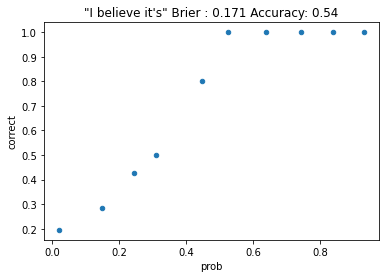

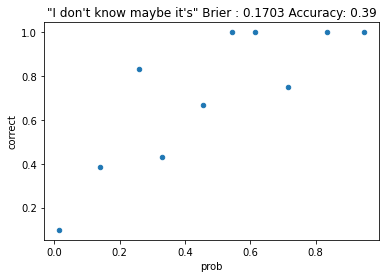

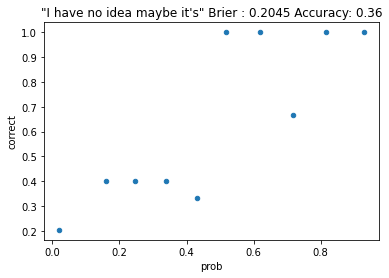

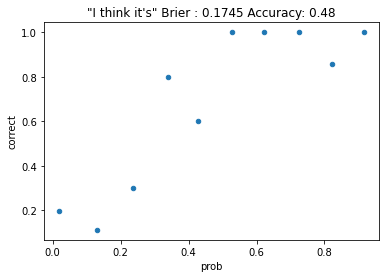

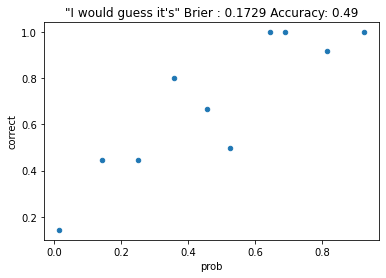

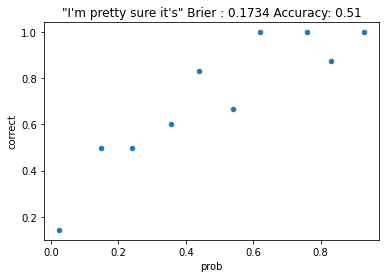

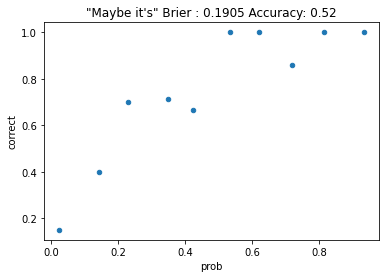

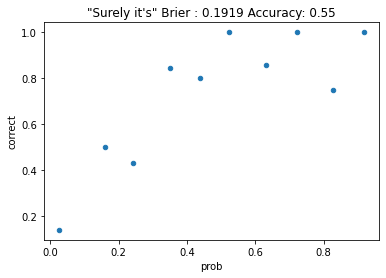

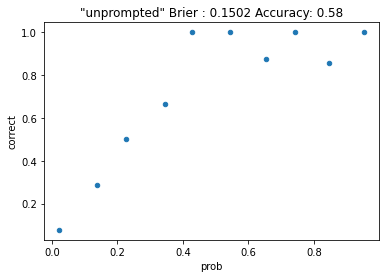

In [22]:
import numpy as np
import sklearn
from sklearn.metrics import brier_score_loss

result['prob'] = result['logprob'].apply(lambda x: np.e**x)

grouped = result.groupby("prefix")
    
for prefix, group in grouped:
    accuracy = group['correct'].mean()
    group['prob_bins'] = pd.cut(np.array(group['prob'].values), 10)
#     group = group.groupby('prob').mean()
    brier_score = brier_score_loss(group['correct'].values, group['prob'].values)
    group = group.groupby('prob_bins').mean().reset_index().sort_values(by='prob_bins').reset_index()
    group.plot.scatter(x='prob', y='correct', title= "\"" + prefix + "\"" + " Brier : " + str(round(brier_score, 4)) + " Accuracy: " + str(round(accuracy, 4)))



# Other stuff

In [ ]:
best_result = pd.DataFrame()

grouped = result.groupby('question')

for question, group in grouped:
    #set a very negative value
    best_prediction = -1000
    
    for m, row in group.iterrows():
        #if the logprob is higher, then set that to be the best value
        if row['logprob'] > best_prediction:
            best_prediction = row['logprob']
            correct = row['correct']
            prediction = row['prediction']
            answer = row['answer']
            prefix = row['prefix']

    best_result = pd.concat([best_result, pd.DataFrame([[question, prefix, best_prediction, prediction, correct, answer]])], axis=0)
best_result.columns = ['question', 'prefix', 'best_prediction', 'prediction', 'correct', 'answer']

In [42]:
best_result.sum()

/tmp/ipykernel_584478/279176661.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  best_result.mean()


best_prediction   -0.94832
correct            0.65000
dtype: float64

In [27]:
best_result.groupby('prefix').sum()

,best_prediction,correct
prefix,,
I believe it's,-3.158652,9
I don't know maybe it's,-2.648109,1
I have no idea maybe it's,-11.766213,0
I think it's,-5.541513,0
I would guess it's,-13.070763,8
I'm pretty sure it's,-6.765428,6
Maybe it's,-17.049725,4
Surely it's,-9.232646,9
unprompted,-25.598928,28
